In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
torch.cuda.empty_cache()

In [3]:
df = pd.read_csv("dataset/NYCTaxiFares.csv")

In [4]:
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [6]:
def haversine(df, lat1, long1, lat2, long2):
    r = 6371
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

In [7]:
df['distance'] = haversine(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [10]:
df['Hour'] = df['EDTdate'].dt.hour
df['Meridian'] = np.where(df['Hour']<12, 'am', 'pm')

In [11]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [12]:
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,Meridian,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [13]:
cat_cols = ['Hour', 'Meridian', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']

In [14]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [15]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [16]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

In [17]:
cats = torch.tensor(cats, dtype=torch.int64).cuda()

In [18]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)

In [19]:
conts = std_scaler.fit_transform(conts)

In [20]:
conts = torch.tensor(conts, dtype=torch.float).cuda()

In [21]:
labels = min_max_scaler.fit_transform(df['fare_amount'].values.reshape(-1, 1))

In [22]:
labels = torch.tensor(labels, dtype=torch.float).reshape(-1, 1).cuda()

In [23]:
cat_size = [len(df[col].cat.categories) for col in cat_cols]

In [24]:
embedding_size = [(size, min(50, (size+1)//2)) for size in cat_size]

In [25]:
class TabularModel(nn.Module):
    def __init__(self, embedding_size, n_cont, out, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in embedding_size])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_embs = sum([nf for ni, nf in embedding_size])
        n_in = n_embs + n_cont
        
        for layer in layers:
            layer_list.append(nn.Linear(n_in, layer))
            layer_list.append(nn.LeakyReLU(negative_slope=0.3, inplace=True))
            layer_list.append(nn.BatchNorm1d(layer))
            layer_list.append(nn.Dropout(p))
            n_in = layer
        
        layer_list.append(nn.Linear(layers[-1], out))
        
        self.layers = nn.Sequential(*layer_list)
            
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.batch_norm(x_cont)
        
        x = torch.cat([x, x_cont], axis=1)
        x = self.layers(x)
        
        return x        

In [26]:
model = TabularModel(embedding_size, conts.shape[1], 1, [224, 128], p=0.4).cuda()

In [27]:
criterion = nn.MSELoss().cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000
batch_size = 60000
test_size = int(batch_size*0.2)
losses = []
val_losses = []

In [28]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

In [29]:
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [30]:
start_time = time.time()

for e in range(epochs):
    y_hat = model(cat_train, cont_train)
    loss = torch.sqrt(criterion(y_hat, y_train))
    losses.append(loss)
    
    with torch.no_grad():
        y_valid = model(cat_test, cont_test)
        val_loss = torch.sqrt(criterion(y_valid, y_test))
        val_losses.append(val_loss)
        
    # display training metrics
    if (e % 100 == 0) or e==0 or e==(epochs-1):
        print("Epoch {}".format(e+1))
        print("Loss: {:.4f} | Validation Loss: {:.4f} ".format(loss, val_loss))
    
    # back propagation
    optim.zero_grad()
    loss.backward()
    optim.step()

end_time = time.time() - start_time

print("\nTraining Duration {:.4f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1
Loss: 0.8668 | Validation Loss: 0.8679 
Epoch 101
Loss: 0.0814 | Validation Loss: 0.0790 
Epoch 201
Loss: 0.0740 | Validation Loss: 0.0722 
Epoch 301
Loss: 0.0725 | Validation Loss: 0.0707 
Epoch 401
Loss: 0.0718 | Validation Loss: 0.0696 
Epoch 501
Loss: 0.0709 | Validation Loss: 0.0693 
Epoch 601
Loss: 0.0703 | Validation Loss: 0.0686 
Epoch 701
Loss: 0.0700 | Validation Loss: 0.0676 
Epoch 801
Loss: 0.0693 | Validation Loss: 0.0678 
Epoch 901
Loss: 0.0692 | Validation Loss: 0.0673 
Epoch 1000
Loss: 0.0689 | Validation Loss: 0.0671 

Training Duration 1.9720 minutes
GPU memory used : 8089600 kb
GPU memory cached : 268435456 kb


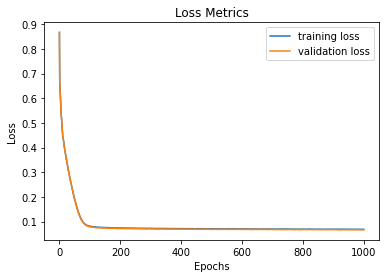

In [31]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [32]:
torch.cuda.empty_cache()

In [33]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'Validation Loss: {loss:.4f}')

Validation Loss: 0.0670


In [34]:
print(f'{"Predicted":>12} {"Actual":>8} {"Difference":>8}')

for i in range(10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2} {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   Predicted   Actual Difference
 1   0.0370   0.0084   0.0286
 2   0.4354   0.0675   0.3679
 3   0.0972   0.1097   0.0125
 4   0.2330   0.2110   0.0220
 5   0.0353   0.0338   0.0015
 6   0.0651   0.0591   0.0060
 7   0.0163   0.0253   0.0091
 8   0.3118   0.2532   0.0586
 9   0.0632   0.0675   0.0043
10   0.1900   0.1603   0.0296


In [35]:
torch.save(model.state_dict(), 'models/taxi_scaled.pt')